<a href="https://colab.research.google.com/github/mujahidali88094/Artificial-Intelligence-Course/blob/main/Naive_Bayes_Classification_Genralized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes Classifier

## Urdu Alphabets Dataset

In [ ]:
import numpy as np 
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
Index_Mapping = {
  0 : "ا",
  1 : "آ",
  2 : "ب",
  3 : "پ",
  4 : "ت",
  5 : "ٹ",
  6 : "ث",
  7 : "ج",
  8 : "چ",
  9 : "ح",
  10 : "خ",
  11 : "د",
  12 : "ڈ",
  13 : "ذ",
  14 : "ر",
  15 : "ڑ",
  16 : "ز",
  17 : "ژ",
  18 : "س",
  19 : "ش",
  20 : "ص",
  21 : "ض",
  22 : "ط",
  23 : "ظ",
  24 : "ع",
  25 : "غ",
  26 : "ف",
  27 : "ق",
  28 : "ک",
  29 : "گ",
  30 : "ل",
  31 : "م",
  32 : "ن",
  33 : "ں",
  34 : "و",
  35 : "ھ",
  36 : "ہ",
  37 : "ء",
  38 : "ی",
  39 : "ے"
}

# Utilities

In [ ]:
# Python3 program to find first and
# last occurrences of a number in a
# given sorted array using binary search

def first(arr, x, n):
    low = 0
    high = n - 1
    res = -1 
    while (low <= high):
        # Normal Binary Search Logic
        mid = (low + high) // 2
        
        if arr[mid] > x:
            high = mid - 1
        elif arr[mid] < x:
            low = mid + 1
        # If arr[mid] is same as x, we
        # update res and move to the left
        # half.
        else:
            res = mid
            high = mid - 1
    return res

def last(arr, x, n):
    low = 0
    high = n - 1
    res = -1
    while(low <= high):
        # Normal Binary Search Logic
        mid = (low + high) // 2

        if arr[mid] > x:
            high = mid - 1
        elif arr[mid] < x:
            low = mid + 1
        # If arr[mid] is same as x, we
        # update res and move to the Right
        # half.
        else:
            res = mid
            low = mid + 1
    return res

def safe_log10(x, eps=1e-10):
    result = np.where(x > eps, x, -10)
    np.log10(result, out=result, where=result > 0)
    return result

def showImage(image):
    plt.imshow(image, interpolation='nearest')
    plt.show()
    return

def showRandomPredictions(predictions,images):
    count = 10
    for c in range(count):
        i = random.randrange(predictions.size)
        print("Prediction: ",Index_Mapping.get(predictions[i]))
        print("Actual Result")
        showImage(images[i].reshape(28,28))
        print("============================================================")
    return

def getSmoothedProb(count,total,feature_count):
    return ((count+1)/(total+feature_count))

def getCountsColumnwise(arr2d,val):
    counts = []
    for col in range(0,arr2d.shape[1]):
        counts.append(np.count_nonzero(arr2d[:,col]==val))
    return np.array(counts)


### Prediction Function

In [ ]:
def predict(image):
    
    gotProbs = [None for i in range(RESULTS_COUNT)]
    for i in range(RESULTS_COUNT):
        temp = 0
        for j in range(FEATURES_COUNT):
            mask = image == j
            temp += probs[i][j][mask].sum()
        temp += results_probs[i]
        gotProbs[i] = pow(10,temp)
        
    return gotProbs.index(max(gotProbs))

### Accuracy Function

In [ ]:
# def getAccuracy(images,results):
#     predictions = np.zeros(images.shape[0])
#     for i in range(0,images.shape[0]):
#         predictions[i] = predict(images[i])
#     matched = np.count_nonzero((predictions == results)==1)
#     accuracy = matched / results.size * 100
#     return accuracy

def getPredictions(images):
    predictions = np.zeros(images.shape[0])
    for i in range(0,images.shape[0]):
        predictions[i] = predict(images[i])
    return predictions

def getAccuracy(predictions,results):
    matched = np.count_nonzero((predictions == results)==1)
    accuracy = matched / results.size * 100
    return accuracy




# Load Data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
urdu_dataset = np.load('/content/gdrive/MyDrive/kaggle/uhat_dataset.npz')

In [ ]:

train_images = urdu_dataset['x_chars_train']
train_results = urdu_dataset['y_chars_train']
test_images = urdu_dataset['x_chars_test']
test_results = urdu_dataset['y_chars_test']


# Removing Unnecssary Details

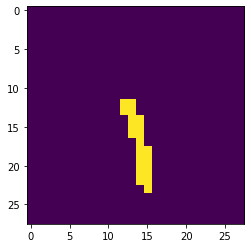

In [ ]:
# making 2 feature only
divider = 127
train_images[(train_images<=divider)]=0
train_images[(train_images>divider)]=1
test_images[(test_images<=divider)]=0
test_images[(test_images>divider)]=1

showImage(test_images[0])

# Transforming images to 1D

In [ ]:
temp = np.ones((train_images.shape[0], train_images.shape[1] ** 2))
for i in range(train_images.shape[0]):
     temp[i] = train_images[i].flatten()
train_images = temp

temp = np.ones((test_images.shape[0], test_images.shape[1] ** 2))
for i in range(test_images.shape[0]):
     temp[i] = test_images[i].flatten()
test_images = temp

# Globals

In [ ]:
FEATURES_COUNT = 2                          # [0,1]
RESULTS_COUNT = len(set(train_results))

# Training

### Probabilites of feature given result ( P(x[i] | y[j]) )

In [ ]:
# probs[i][j] means probability of x[i] given y[j]

probs = [[None for j in range(FEATURES_COUNT)] for i in range(RESULTS_COUNT)]

for i in range(0,RESULTS_COUNT):
    
    start = first( train_results, i, len(train_images) )
    end   = last ( train_results, i, len(train_images) )
    images = train_images[start:end+1]
    
    for j in range(0,FEATURES_COUNT):
        
        # without smoothing
        #probs[i][j] = (getCountsColumnwise(images,j) / images.shape[0])
        
        # with smoothing
        probs[i][j] = getSmoothedProb(getCountsColumnwise(images,j),images.shape[0],FEATURES_COUNT)
        
        probs[i][j] = safe_log10(probs[i][j])


### Overall probabilities of results ( P(y[i]) )

In [ ]:
results_probs = [None for i in range(RESULTS_COUNT)]
for i in range(RESULTS_COUNT):
    results_probs[i] = safe_log10(np.count_nonzero(train_results == i)/train_results.size)

# Evaluation on Training Data

In [ ]:
train_predictions = getPredictions(train_images)

print("Accuracy: ",getAccuracy(train_predictions,train_results))

Accuracy:  56.590652358090935


Prediction:  ے
Actual Result


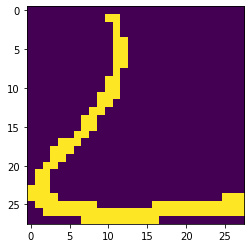

Prediction:  ط
Actual Result


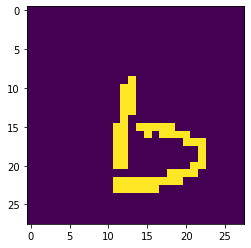

Prediction:  ڑ
Actual Result


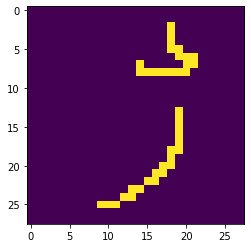

Prediction:  ح
Actual Result


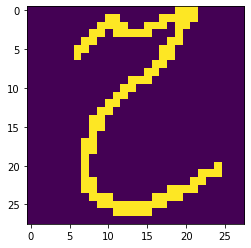

Prediction:  ص
Actual Result


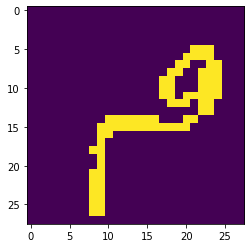

Prediction:  خ
Actual Result


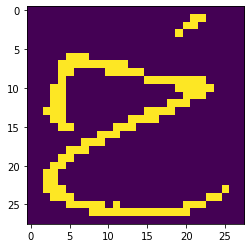

Prediction:  ظ
Actual Result


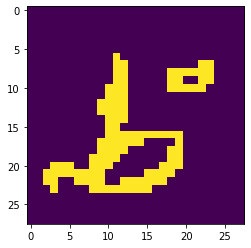

Prediction:  ء
Actual Result


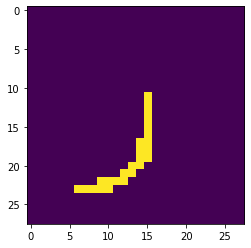

Prediction:  گ
Actual Result


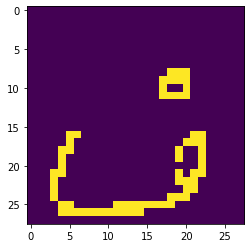

Prediction:  ز
Actual Result


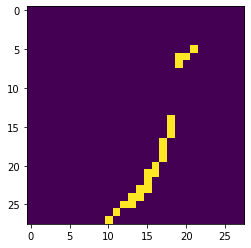

In [ ]:
showRandomPredictions(train_predictions,train_images)

# Evaluation on Testing Data

In [ ]:
test_predictions = getPredictions(test_images)

print("Accuracy: ",getAccuracy(test_predictions,test_results))

Accuracy:  55.40983606557377


Prediction:  ت
Actual Result


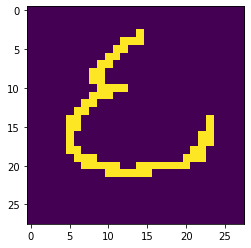

Prediction:  ب
Actual Result


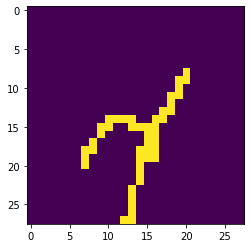

Prediction:  غ
Actual Result


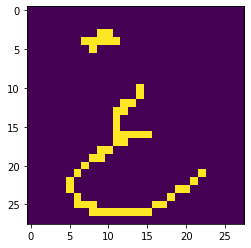

Prediction:  ڑ
Actual Result


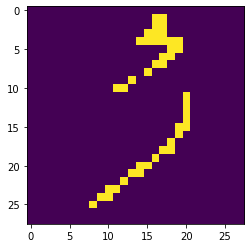

Prediction:  ء
Actual Result


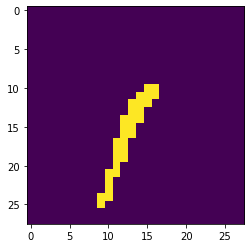

Prediction:  ض
Actual Result


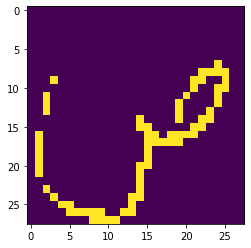

Prediction:  ظ
Actual Result


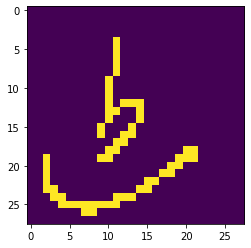

Prediction:  ث
Actual Result


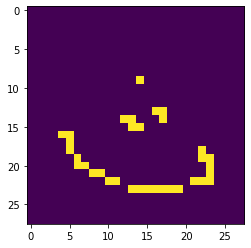

Prediction:  غ
Actual Result


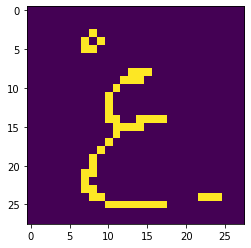

Prediction:  ط
Actual Result


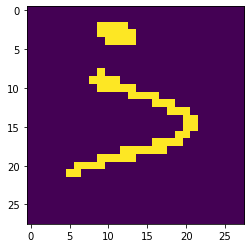

In [ ]:
showRandomPredictions(test_predictions,test_images)